In [39]:
!pip install transformers==4.28.0 --no-deps
!pip install tokenizers==0.13.3 --no-deps

  Using cached tokenizers-0.13.3.tar.gz (314 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  error: subprocess-exited-with-error
  
  × Building wheel for tokenizers (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for tokenizers
Failed to build tokenizers
ERROR: ERROR: Failed to build installable wheels for some pyproject.toml based projects (tokenizers)


In [40]:
import re
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize

In [41]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [42]:
!pip install langchain_community
!pip install replicate
!pip install pandas
!pip install -U langchain langchain-community langchain-experimental replicate

In [43]:
from google.colab import userdata
import os

api_token = userdata.get('api_token')

os.environ['REPLICATE_API_TOKEN'] = api_token

In [44]:
from langchain_community.llms import Replicate

llm = Replicate(
    model="ibm-granite/granite-3.3-8b-instruct",
    # model_kwargs={
    #     "temperature": 0.0,
    #     "top_k": 1,
    #     "top_p": 1.0,
    #     "max_tokens": 5,
    #     "min_tokens": 1,
    #     "repetition_penalty": 1.0,
    #     "random_seed": 42,
    #     "stop_sequences": ["\n"]
    # }
)


In [45]:
try:
    true_df = pd.read_csv('/content/True.csv', engine='python')
    fake_df = pd.read_csv('/content/Fake.csv', engine='python')
except Exception as e:
    print(f"Error reading CSV: {e}")

In [46]:
true_df['label'] = 1
fake_df['label'] = 0

df = pd.concat([true_df, fake_df])

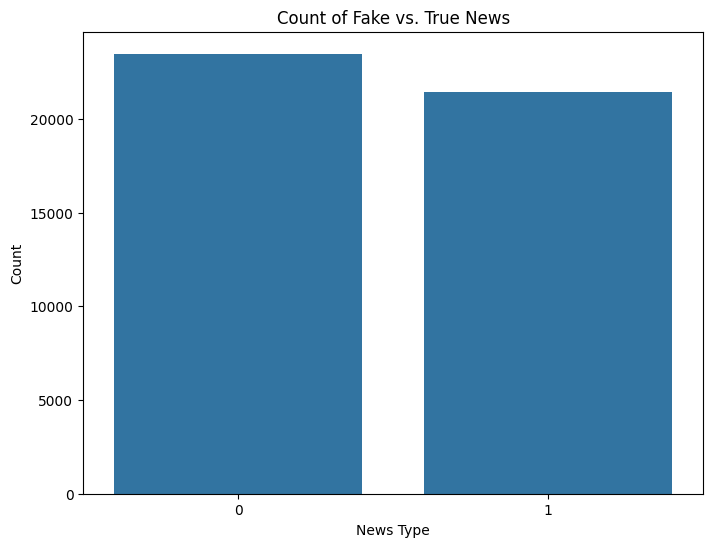

In [47]:
plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=df)
plt.title('Count of Fake vs. True News')
plt.xlabel('News Type')
plt.ylabel('Count')
plt.show()

In [48]:
df.columns

Index(['title', 'text', 'subject', 'date', 'label'], dtype='object')

In [49]:
df.drop(['subject'], axis=1, inplace=True)
df.drop(['date'], axis=1, inplace=True)
df

,title,text,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,1
...,...,...,...
23476,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,0
23477,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,0
23478,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,0
23479,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,0


In [50]:
print(df.duplicated().sum())

5793


In [51]:
df.drop_duplicates(inplace=True)

In [52]:
df.shape

(39105, 3)

In [53]:
df.isnull().sum()

,0
title,0
text,0
label,0


In [54]:
stop_words = set(stopwords.words("english"))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

In [55]:
def clean(text):

    text = text.lower()

    text = re.sub(r"<.*?>", "", text)
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    text = re.sub(r"http\S+|www.\S+", "", text)

    return text

def preprocess(text):
    text = clean(text)
    words = text.split()
    processed_words = [
        stemmer.stem(lemmatizer.lemmatize(word))
        for word in words if word not in stop_words
    ]
    return " ".join(processed_words)

In [56]:
df["clean_text"] = df["text"].apply(preprocess)

In [57]:
df["content"] = df["title"] + " " + df["clean_text"]

In [58]:
def predict_granite(text):
    prompt = f"Classify the following news strictly as either 'True' or 'Fake':\n\n{text}\n\nAnswer:"

    try:
        response = llm(prompt)
        if response is None:
            return -1

        response = str(response).strip().lower()

        if "true" in response and "fake" not in response:
            return 1
        elif "fake" in response and "true" not in response:
            return 0
        else:
            return -1
    except Exception as e:
        print(f"Error: {e}")
        return -1

df_sample = df.sample(100, random_state=42)  # ambil 100 berita saja
df_sample['granite_prediction'] = df_sample['content'].apply(predict_granite)


In [59]:
df_sample

,title,text,label,clean_text,content,granite_prediction
7853,This Church Treasurer Is Going To Jail For A ...,A church treasurer from Ohio is going to jail ...,0,church treasur ohio go jail five year blow chu...,This Church Treasurer Is Going To Jail For A ...,0
10966,SENATOR FEINSTEIN Shocks CNN Anchor With “Prec...,"What s all the fuss about if there s no there,...",0,fuss anyon els sicken left effort discredit pr...,SENATOR FEINSTEIN Shocks CNN Anchor With “Prec...,0
22351,Hillary Clinton Supporters Now Calling for a R...,The person who received the most votes free f...,0,person receiv vote free interfer tamper need w...,Hillary Clinton Supporters Now Calling for a R...,-1
8871,U.S. appeals court upholds conviction over sha...,(Reuters) - A divided federal appeals court on...,1,reuter divid feder appeal court tuesday gave u...,U.S. appeals court upholds conviction over sha...,1
14359,Kenya's Supreme Court upholds Kenyatta's presi...,NAIROBI (Reuters) - Kenya s Supreme Court on M...,1,nairobi reuter kenya suprem court monday uphel...,Kenya's Supreme Court upholds Kenyatta's presi...,1
...,...,...,...,...,...,...
8955,"For Obama, setbacks from a divided Supreme Court",WASHINGTON (Reuters) - The U.S. Supreme Court ...,1,washington reuter u suprem court break summer ...,"For Obama, setbacks from a divided Supreme Cou...",1
12906,Indonesia condemns U.S. decision to recognize ...,"Bogor, INDONESIA (Reuters) - Indonesian Presid...",1,bogor indonesia reuter indonesian presid joko ...,Indonesia condemns U.S. decision to recognize ...,1
4128,Poll Shows Hillary Leading Trump With This Su...,"Until today, not one national poll had Clinton...",0,today one nation poll clinton lead male voter ...,Poll Shows Hillary Leading Trump With This Su...,-1
109,Factbox: What's in the final U.S. Republican t...,(Reuters) - The U.S. Congress is expected to v...,1,reuter u congress expect vote week sweep debtf...,Factbox: What's in the final U.S. Republican t...,-1


📊 Model Evaluation (IBM Granite - Zero-Shot)
Accuracy  : 0.9254
Precision : 0.9545
Recall    : 0.9333
F1-score  : 0.9438

Classification Report:

              precision    recall  f1-score   support

        Fake       0.87      0.91      0.89        22
        Real       0.95      0.93      0.94        45

    accuracy                           0.93        67
   macro avg       0.91      0.92      0.92        67
weighted avg       0.93      0.93      0.93        67



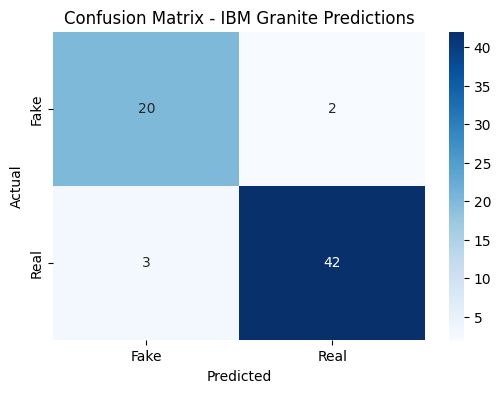

In [63]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix
)
import seaborn as sns
import matplotlib.pyplot as plt


valid_preds = df_sample["granite_prediction"] != -1
y_true = df_sample.loc[valid_preds, "label"]
y_pred = df_sample.loc[valid_preds, "granite_prediction"]


acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print("📊 Model Evaluation (IBM Granite - Zero-Shot)")
print(f"Accuracy  : {acc:.4f}")
print(f"Precision : {prec:.4f}")
print(f"Recall    : {rec:.4f}")
print(f"F1-score  : {f1:.4f}")
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=["Fake", "Real"]))


cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - IBM Granite Predictions")
plt.show()